In [1]:
from pytesseract import Output
from imutils.object_detection import non_max_suppression
import pytesseract
import argparse
import cv2
import os
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import PIL
import imutils

In [2]:
min_conf = 0
image_path = "testing.jpg"
current = os.getcwd()
image_path = os.path.join(current,image_path)

In [71]:
image = cv2.imread(image_path)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
results = pytesseract.image_to_data(rgb, output_type=Output.DICT)

In [28]:
for i in range(0, len(results["text"])):
    x = results["left"][i]
    y = results["top"][i]
    w = results["width"][i]
    h = results["height"][i]
    text = results["text"][i]
    conf = int(float(results["conf"][i]))
    if len(text.strip()) > 1:
        print("Confidence: {}".format(conf))
        print("Text: {}".format(text),len(text))
        print("")
        text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX,1.2, (0, 0, 255), 3)

Confidence: 55
Text: REPUBLIC 8

Confidence: 92
Text: OF 2

Confidence: 52
Text: TUNIS'* 7

Confidence: 47
Text: ogee 4

Confidence: 91
Text: EL 2

Confidence: 91
Text: SAMAN 5

Confidence: 95
Text: MOHAMED 7

Confidence: 10
Text: TUNISLAN/ 9

Confidence: 0
Text: 09 2

Confidence: 66
Text: 1991 4

Confidence: 63
Text: 06016323 8

Confidence: 0
Text: eyerren 7

Confidence: 0
Text: FRANCE 6

Confidence: 0
Text: /Ls 3

Confidence: 0
Text: —s 2

Confidence: 19
Text: NEE 3



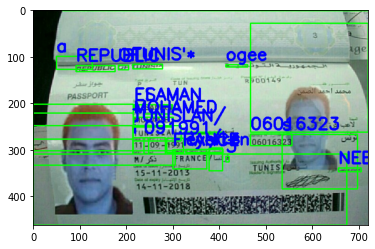

In [29]:
plt.imshow(image)
plt.show()

# trying again to externalize the detection process using ROIs provides by EAST model

In [3]:
def decode_predictions(scores, geometry,min_confidence):
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []
    for y in range(0, numRows):
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]
        for x in range(0, numCols):
            if scoresData[x] < min_confidence:
                continue
            
            (offsetX, offsetY) = (x * 4.0, y * 4.0)
            
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)
            
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
    return (rects, confidences)

In [4]:
east_path = os.path.join(current,"frozen_east_text_detection.pb")
width = 960
height = 640
min_confidence = 0.5
image = cv2.imread(image_path)
images = ["testing.jpg","testing2.jpg","testing3.png"]
image = np.array(Image.fromarray(image).resize((width,height),resample=PIL.Image.BICUBIC))

In [5]:
layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
net = cv2.dnn.readNet(east_path)

In [6]:
blob = cv2.dnn.blobFromImage(image, 1.0, (width, height),(123.68, 116.78, 103.94), swapRB=True, crop=False)
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

(rects, confidences) = decode_predictions(scores, geometry,min_confidence)
boxes = non_max_suppression(np.array(rects), probs=confidences)

In [7]:
print(len(rects))

937


In [8]:
results = []
for (startX, startY, endX, endY) in boxes:
    
    roi = orig[startY:endY, startX:endX]
    
    config = ("-l eng --oem 1 --psm 7")
    text = pytesseract.image_to_string(roi, config=config)
    results.append(((startX, startY, endX, endY), text))

NameError: name 'orig' is not defined

In [9]:
print(len(results))

0


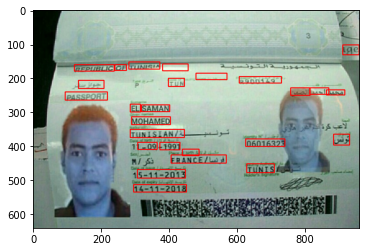

In [137]:
im = image
for r in results:
    ((startX, startY, endX, endY), text) = r
    cv2.rectangle(im,(startX, startY),(endX, endY),(255,0,0),2)
plt.imshow(im)
plt.show()

In [170]:
texts =[ t[1] for t in results]
texts

['MOHAMED\n',
 'PASSPORT\n',
 'SAMAN\n',
 '060162927\n',
 '44-11-2018\n',
 'TIINIGIA\n',
 '',
 'FRPANCE/Lid\n',
 'TUNISILAN/<\n',
 'OF\n',
 '.~4991\n',
 'Age\n',
 '§-11-2012\n',
 'FUN\n',
 'WTS\n',
 'auadl\n',
 'SGnniio”\n',
 'b\n',
 'TUNIS\n',
 'EL\n',
 '1_9go\n',
 'us\n',
 'on oo\n',
 '—E\n',
 'such A\n',
 'oe et\n']

In [21]:
def traditional_processingA(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 5))
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    grad = np.absolute(grad)
    (minVal, maxVal) = (np.min(grad), np.max(grad))
    grad = (grad - minVal) / (maxVal - minVal)
    grad = (grad * 255).astype("uint8")
    grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, kernel)
    thresh = cv2.threshold(grad, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    thresh = cv2.dilate(thresh, None, iterations=3)
    return thresh

In [ ]:
def traditional_processingB(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    thresh = cv2.dilate(thresh, None, iterations=3)
    return thresh

In [11]:
def traditional_ROI_extraction(image):
    image = traditional_processing(image)
    cnts = cv2.findContours(image.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    boxes = []
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        (xstart,ystart,xend,yend)=(x,y,x+w,y+h)
        boxes.append((xstart,ystart,xend,yend))
    return boxes

In [12]:
def model_based_ROI_extraction(image):
    layerNames = ["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"]
    net = cv2.dnn.readNet(east_path)
    blob = cv2.dnn.blobFromImage(image, 1.0, (width, height),(128, 128, 128), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(layerNames)
    (rects, confidences) = decode_predictions(scores, geometry,min_confidence)
    boxes = non_max_suppression(np.array(rects), probs=confidences)
    return boxes

In [13]:
def ROIs2Texts(image,boxes,config):
    texts = []
    for box in boxes:
        (xstart,ystart,xend,yend)=box
        roi = image[ystart:yend, xstart:xend]
        text = pytesseract.image_to_string(roi, config=config)
        texts.append(text)
    return texts

In [14]:
def drawROIs(image,boxes):
    im = image.copy()
    for box in boxes:
        (startX, startY, endX, endY) = box
        cv2.rectangle(im,(startX, startY),(endX, endY),(255,0,0),2)
    return im

In [15]:
def white_patch(image, boxes):
    im = np.zeros(image.shape)
    for box in boxes:
        (startX, startY, endX, endY) = box
        cv2.rectangle(im,(startX, startY),(endX, endY),(255,255,255),-1)
    return im

In [16]:
def visualize_output(tradbinary,trad,modelbinary,model):
    fig = plt.figure(figsize=(15, 10))
    rows = 2
    columns = 2
    fig.add_subplot(rows, columns, 1)
    plt.imshow(tradbinary)
    plt.title('binary by trad')
    plt.axis('off')
    fig.add_subplot(rows, columns, 2)
    plt.imshow(modelbinary)
    plt.title('binary by model')
    plt.axis('off')
    fig.add_subplot(rows, columns, 3)
    plt.imshow(trad)
    plt.title('trad')
    plt.axis('off')
    fig.add_subplot(rows, columns, 4)
    plt.imshow(model)
    plt.title('model')
    plt.axis('off')

In [17]:
east_path = os.path.join(current,"frozen_east_text_detection.pb")
width = 960
height = 640
min_confidence = 0.5
images = ["testing.jpg","testing2.png","testing3.png"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


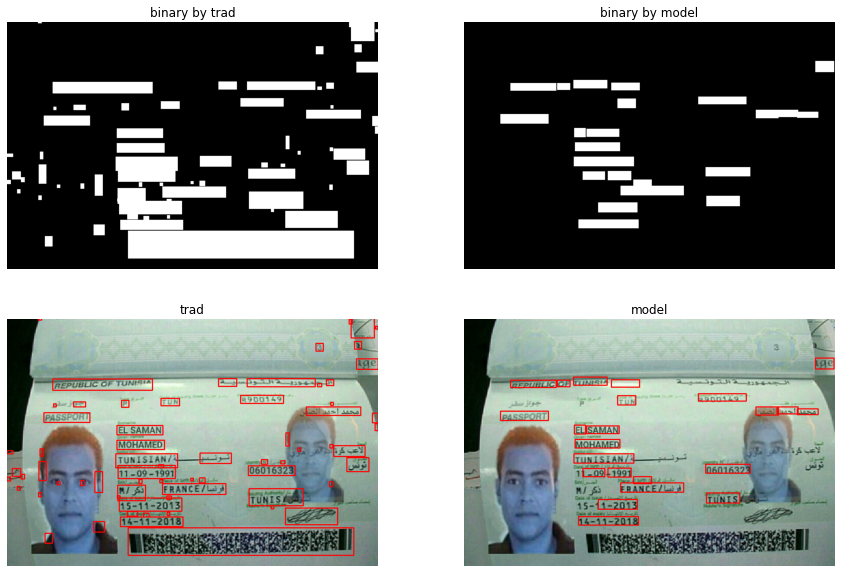

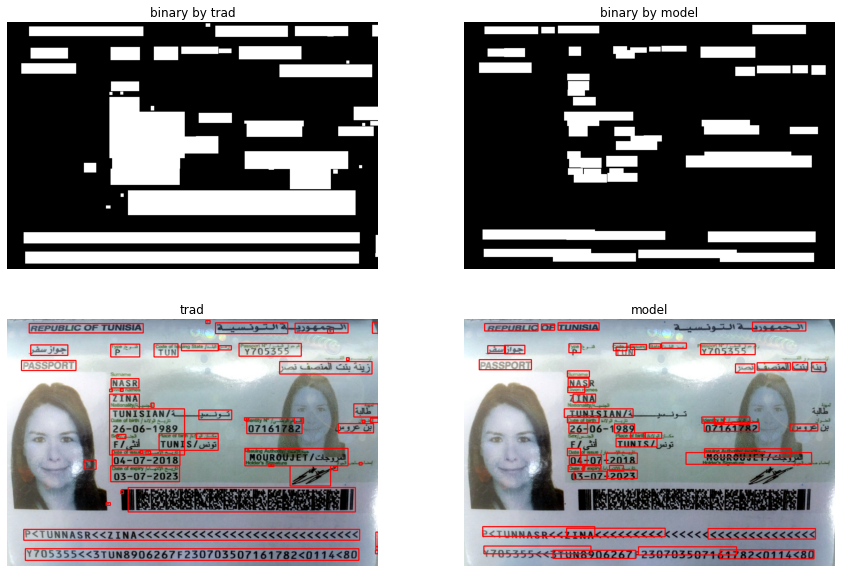

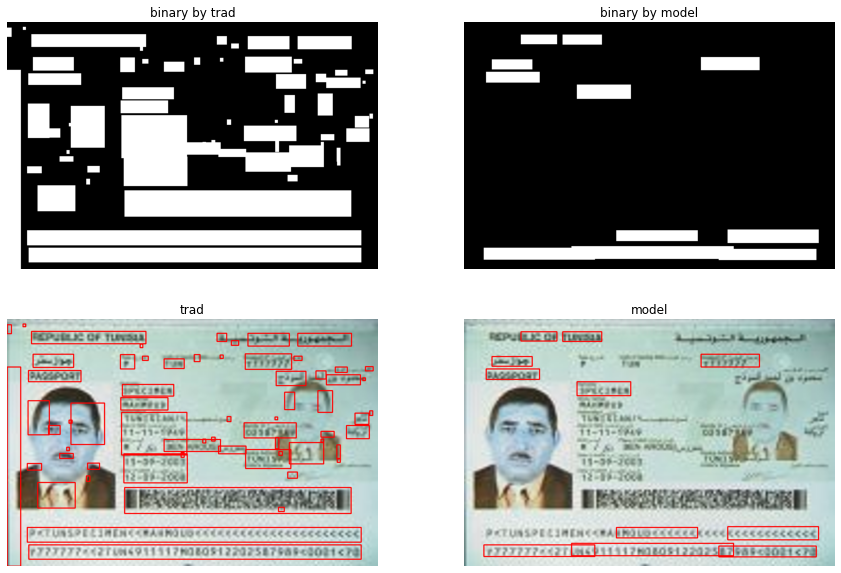

In [22]:
for im in images:
    im = os.path.join(current,im)
    image = cv2.imread(im)
    image = np.array(Image.fromarray(image).resize((width,height),resample=PIL.Image.BICUBIC))
    trad_boxes = traditional_ROI_extraction(image)
    model_boxes = model_based_ROI_extraction(image)
    trad = drawROIs(image,trad_boxes)
    model = drawROIs(image,model_boxes)
    tradbinary = white_patch(image,trad_boxes)
    modelbinary = white_patch(image,model_boxes)
    visualize_output(tradbinary,trad,modelbinary,model)